# Getting and Analysing the time series dataset

In [5]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv

--2024-06-13 06:23:55--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45039 (44K) [text/plain]
Saving to: ‘monthly-sunspots.csv’

monthly-sunspots.cs 100%[===================>]  43.98K  --.-KB/s    in 0.007s  

2024-06-13 06:23:55 (6.29 MB/s) - ‘monthly-sunspots.csv’ saved [45039/45039]



In [6]:
import pandas as pd
df = pd.read_csv("monthly-sunspots.csv")
df.head()

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


In [7]:
# converting to datetime type
df['Month'] = pd.to_datetime(df['Month'])

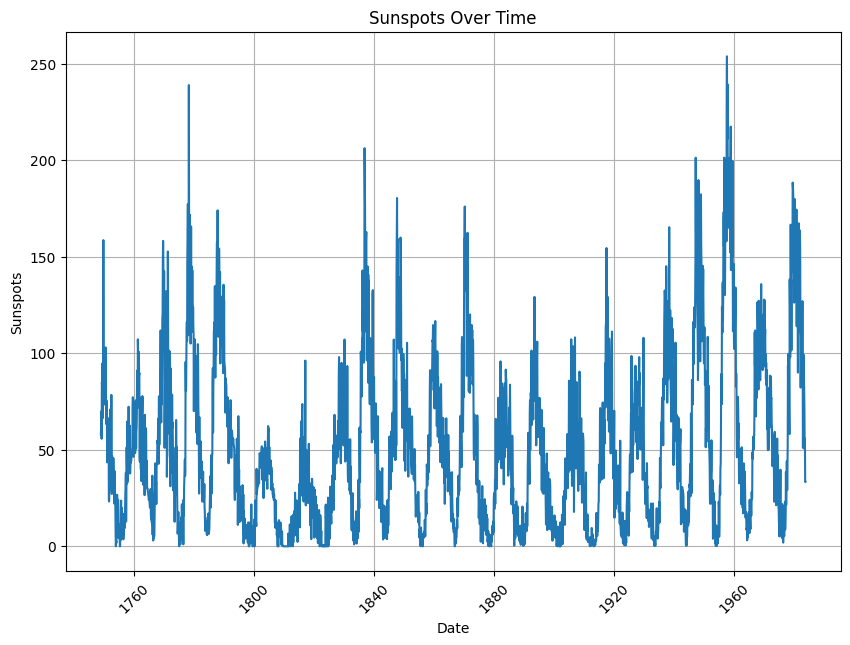

In [8]:
# plotting sunspots vs date

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(df['Month'], df['Sunspots'])
plt.title('Sunspots Over Time')
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Train-Test Split
Setting HORIZON to be 1 and WINDOW_SIZE as 4

In [9]:
sun_spots = df["Sunspots"].to_numpy()

In [10]:
import numpy as np

def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

sswindows, sslabels = make_windows(sun_spots, window_size=4)

In [11]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(sswindows, sslabels, test_split=0.2)
len(train_windows), len(test_windows)

(2252, 564)

# Building RNN from scratch

In [53]:
import random
class RNN:
  def __init__(self):
      self.w1 = random.random()
      self.w2 = random.random()
      self.w3 = random.random()
      self.b1 = random.random()
      self.b2 = random.random()

  def forward(self, inputs):
    hidden_list = []
    h_temp = 0
    for input in inputs:
      h_next = input * self.w1 + h_temp * self.w2 + self.b1
      hidden_list.append(h_next)
      h_temp = h_next
    output = h_next * self.w3 + self.b2
    return output, hidden_list

  def backward(self, inputs, output, target, hidden_list):
    dw3 = 2 * (output - target) * hidden_list[-1]

    db2 = 2 * (output - target)

    db1 = 2 * (output - target) * self.w3
    temp_sum = 0
    temp_const = 1
    for i in range(len(hidden_list)):
      temp_sum += temp_const
      temp_const *= self.w2
    db1 *= temp_sum

    dw1 = 2 * (output - target) * self.w3
    temp_sum = 0
    for i in range(len(hidden_list)):
      temp_const = inputs[-1*(i+1)] * pow(self.w2, i)
      temp_sum += temp_const
    dw1 *= temp_sum

    dw2 = 2 * (output - target) * self.w3
    temp_sum = 0
    for i in range(len(hidden_list)-1):
      temp_const = hidden_list[-1 * (i+2)] * pow(self.w2, i)
      temp_sum += temp_const
    dw2 *= temp_sum

    for dparam in [dw1, dw2, dw3, db1, db2]:
      np.clip(dparam, -5, 5, out=dparam)

    return [dw1, dw2, dw3, db1, db2]

  def update(self, grads, lr):
    self.w1 -= lr * grads[0]
    self.w2 -= lr * grads[1]
    self.w3 -= lr * grads[2]
    self.b1 -= lr * grads[3]
    self.b2 -= lr * grads[4]

  def train(self, windows, labels, batch_size=32, lr=0.0001, epochs=20):

    for j in range(epochs):
      loss = 0
      grads = [0, 0, 0, 0, 0]

      for i in range(len(windows)):
        window = windows[i]
        label = labels[i]

        output, hidden_list = self.forward(window)

        loss += (output - label) ** 2
        grad = self.backward(window, output, label, hidden_list)

        for f in range(len(grads)):
          grads[f] += grad[f]

        if (i+1) % batch_size == 0:
          for k in range(len(grads)):
            grads[k] /= batch_size
          self.update(grads, lr=lr)
          grads = [0, 0, 0, 0, 0]


      print(f"Epoch: {j+1}, MSE: {loss / len(windows)}")

  def test(self, windows, targets):
    loss = 0
    preds = []
    for i in range(len(windows)):
      window = windows[i]
      target = targets[i]

      output, _ = self.forward(window)
      preds.append(output)

      loss += (output - target) ** 2

    return preds, loss

rnn = RNN()
rnn.train(train_windows, train_labels)

Epoch: 1, MSE: [355.19766332]
Epoch: 2, MSE: [313.48538147]
Epoch: 3, MSE: [284.28940676]
Epoch: 4, MSE: [265.27075435]
Epoch: 5, MSE: [253.48557233]
Epoch: 6, MSE: [246.23835008]
Epoch: 7, MSE: [241.88099108]
Epoch: 8, MSE: [239.13046345]
Epoch: 9, MSE: [237.36950589]
Epoch: 10, MSE: [236.37370518]
Epoch: 11, MSE: [235.81696287]
Epoch: 12, MSE: [235.48406996]
Epoch: 13, MSE: [235.28119832]
Epoch: 14, MSE: [235.1677007]
Epoch: 15, MSE: [235.09463279]
Epoch: 16, MSE: [235.05213373]
Epoch: 17, MSE: [235.02871602]
Epoch: 18, MSE: [235.01848089]
Epoch: 19, MSE: [235.01791411]
Epoch: 20, MSE: [235.02072952]


In [57]:
test_preds, test_loss = rnn.test(test_windows, test_labels)
print("Test MSE: ", test_loss / len(test_windows))

Test MSE:  [369.3630654]


# Plotting Test predictions and Test Labels

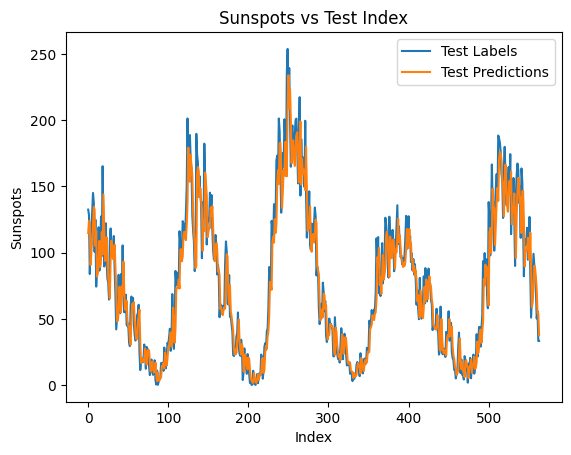

In [60]:
import matplotlib.pyplot as plt

# Generate indices
indices = range(len(test_preds))

# Plotting the lists against their indices
plt.plot(indices, test_labels, label='Test Labels')
plt.plot(indices, test_preds, label='Test Predictions')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Sunspots')
plt.title('Sunspots vs Test Index')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()